In [1]:
# From Alex Staravoitau
# https://github.com/navoshta/KITTI-Dataset/blob/master/kitti-dataset.ipynb

In [2]:
import numpy as np
import pykitti

In [3]:
basedir = 'data/'

date = '2011_09_26'
drive = '0002'
calib_dir = 'data/2011_09_26'

In [4]:
def load_dataset(date, drive, calibrated=False, frame_range=None):
    """
    Loads the dataset with `date` and `drive`.
    
    Parameters
    ----------
    date        : Dataset creation date.
    drive       : Dataset drive.
    calibrated  : Flag indicating if we need to parse calibration data. Defaults to `False`.
    frame_range : Range of frames. Defaults to `None`.

    Returns
    -------
    Loaded dataset of type `raw`.
    """
    dataset = pykitti.raw(basedir, date, drive)

    # Load the data
    if calibrated:
        dataset.load_calib()  # Calibration data are accessible as named tuples
    dataset.load_timestamps()  # Timestamps are parsed into datetime objects
    dataset.load_oxts()  # OXTS packets are loaded as named tuples
    dataset.load_gray()  # Left/right images are accessible as named tuples
    dataset.load_rgb()  # Left/right images are accessible as named tuples
    dataset.load_velo()  # Each scan is a Nx4 array of [x,y,z,reflectance]
    dataset.load_

    np.set_printoptions(precision=4, suppress=True)
    print('\nDrive: ' + str(dataset.drive))
    print('\nFrame range: ' + str(dataset.frame_range))

    if calibrated:
        print('\nIMU-to-Velodyne transformation:\n' + str(dataset.calib.T_velo_imu))
        print('\nGray stereo pair baseline [m]: ' + str(dataset.calib.b_gray))
        print('\nRGB stereo pair baseline [m]: ' + str(dataset.calib.b_rgb))

    return dataset

In [5]:
dataset = load_dataset(date, drive)

Loading OXTS timestamps from 2011_09_26_drive_0002_sync...
Found 77 timestamps...
done.
Loading OXTS data from 2011_09_26_drive_0002_sync...
Found 77 OXTS measurements...
done.
Loading monochrome images from 2011_09_26_drive_0002_sync...
Found 77 image pairs...
done.
Loading color images from 2011_09_26_drive_0002_sync...
Found 77 image pairs...
done.
Found 77 Velodyne scans...
done.

Drive: 2011_09_26_drive_0002_sync

Frame range: None


In [6]:
# dataset.velo[20][0:30]

In [7]:
import parseTrackletXML as xmlParser

In [8]:
def load_tracklets_for_frames(n_frames, xml_path):
    """
    Loads dataset labels also referred to as tracklets, saving them individually for each frame.

    Parameters
    ----------
    n_frames    : Number of frames in the dataset.
    xml_path    : Path to the tracklets XML.

    Returns
    -------
    Tuple of dictionaries with integer keys corresponding to absolute frame numbers and arrays as values. First array
    contains coordinates of bounding box vertices for each object in the frame, and the second array contains objects
    types as strings.
    """
    tracklets = xmlParser.parseXML(xml_path)

    frame_tracklets = {}
    frame_tracklets_types = {}
    for i in range(n_frames):
        frame_tracklets[i] = []
        frame_tracklets_types[i] = []

    # loop over tracklets
    for i, tracklet in enumerate(tracklets):
        # this part is inspired by kitti object development kit matlab code: computeBox3D
        h, w, l = tracklet.size
        # in velodyne coordinates around zero point and without orientation yet
        # See kitti_tracklet_box.jpg for reference
        trackletBox = np.array([
            [-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2],
            [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2],
            [0.0, 0.0, 0.0, 0.0, h, h, h, h]
        ])
        # loop over all data in tracklet
        for translation, rotation, state, occlusion, truncation, amtOcclusion, amtBorders, absoluteFrameNumber in tracklet:
            # determine if object is in the image; otherwise continue
            if truncation not in (xmlParser.TRUNC_IN_IMAGE, xmlParser.TRUNC_TRUNCATED):
                continue
            # re-create 3D bounding box in velodyne coordinate system
            yaw = rotation[2]  # other rotations are supposedly 0
            assert np.abs(rotation[:2]).sum() == 0, 'object rotations other than yaw given!'
            rotMat = np.array([
                [np.cos(yaw), -np.sin(yaw), 0.0],
                [np.sin(yaw), np.cos(yaw), 0.0],
                [0.0, 0.0, 1.0]
            ])
            cornerPosInVelo = np.dot(rotMat, trackletBox) + np.tile(translation, (8, 1)).T
            frame_tracklets[absoluteFrameNumber] = frame_tracklets[absoluteFrameNumber] + [cornerPosInVelo]
            frame_tracklets_types[absoluteFrameNumber] = frame_tracklets_types[absoluteFrameNumber] + [
                tracklet.objectType]

    return (frame_tracklets, frame_tracklets_types)

In [9]:
tracklet_rects, tracklet_types = load_tracklets_for_frames(len(dataset.velo), 'data/{}/{}_drive_{}_sync/tracklet_labels.xml'.format(date, date, drive))

parsing tracklet file data/2011_09_26/2011_09_26_drive_0002_sync/tracklet_labels.xml
file contains 3 tracklets
loaded 3 tracklets


In [10]:
print(np.array(dataset.velo).shape)
print(len(tracklet_rects[0]))

(77,)
2


In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [12]:
colors = {
    'Car': 'b',
    'Tram': 'r',
    'Cyclist': 'g',
    'Van': 'c',
    'Truck': 'm',
    'Pedestrain': 'y',
    'Sitter': 'k'
}
axes_limits = [
    [-40, 80], # X axis range
    [-20, 20], # Y axis range
    [-3, 10], # Z axis range
]
axes_str = ['X', 'Y', 'Z']
def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    # See kitti_tracklet_box.jpg for reference
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)

In [13]:
def display_frame_statistics(dataset, tracklet_rects, tracklet_types, frame, points=0.2):
    """
    Displays statistics for a single frame. Draws camera data, 3D plot of the lidar point cloud data and point cloud
    projections to various planes.
    
    Parameters
    ----------
    dataset         : `raw` dataset.
    tracklet_rects  : Dictionary with tracklet bounding boxes coordinates.
    tracklet_types  : Dictionary with tracklet types.
    frame           : Absolute number of the frame.
    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.
    """
            
    print('Frame timestamp: ' + str(dataset.timestamps[frame]))
    # Draw camera data
    f, ax = plt.subplots(2, 2, figsize=(15, 5))
    ax[0, 0].imshow(dataset.gray[frame].left, cmap='gray')
    ax[0, 0].set_title('Left Gray Image (cam0)')
    ax[0, 1].imshow(dataset.gray[frame].right, cmap='gray')
    ax[0, 1].set_title('Right Gray Image (cam1)')
    ax[1, 0].imshow(dataset.rgb[frame].left)
    ax[1, 0].set_title('Left RGB Image (cam2)')
    ax[1, 1].imshow(dataset.rgb[frame].right)
    ax[1, 1].set_title('Right RGB Image (cam3)')
    plt.show()

    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    velo_range = range(0, dataset.velo[frame].shape[0], points_step)
    velo_frame = dataset.velo[frame][velo_range, :]      
    def draw_point_cloud(ax, title, axes=[0, 1, 2]):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """
        ax.scatter(*np.transpose(velo_frame[:, axes]), s=point_size, c=velo_frame[:, 3], cmap='gray')
        ax.set_title(title)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])              
        for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
            draw_box(ax, t_rects, axes=axes, color=colors[t_type])
            
    # Draw point cloud data as 3D plot
    f2 = plt.figure(figsize=(15, 8))
    ax2 = f2.add_subplot(111, projection='3d')                    
    draw_point_cloud(ax2, 'Velodyne scan')
    plt.show()
    
    # Draw point cloud data as plane projections
    f, ax3 = plt.subplots(3, 1, figsize=(15, 25))
    draw_point_cloud(
        ax3[0], 
        'Velodyne scan, XZ projection (Y = 0), the car is moving in direction left to right', 
        axes=[0, 2] # X and Z axes
    )
    draw_point_cloud(
        ax3[1], 
        'Velodyne scan, XY projection (Z = 0), the car is moving in direction left to right', 
        axes=[0, 1] # X and Y axes
    )
    draw_point_cloud(
        ax3[2], 
        'Velodyne scan, YZ projection (X = 0), the car is moving towards the graph plane', 
        axes=[1, 2] # Y and Z axes
    )
    plt.show()

Frame timestamp: 2011-09-26 13:02:46.395189


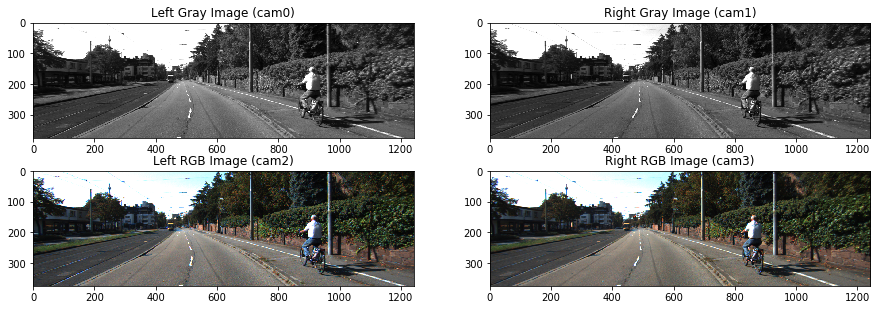

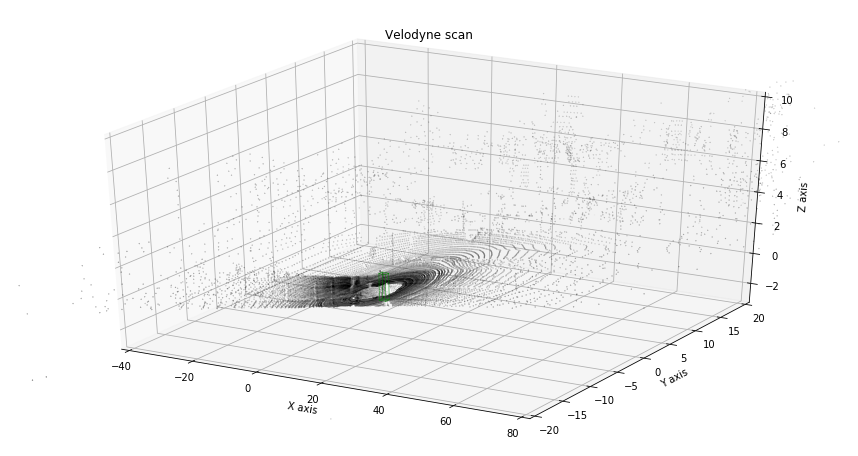

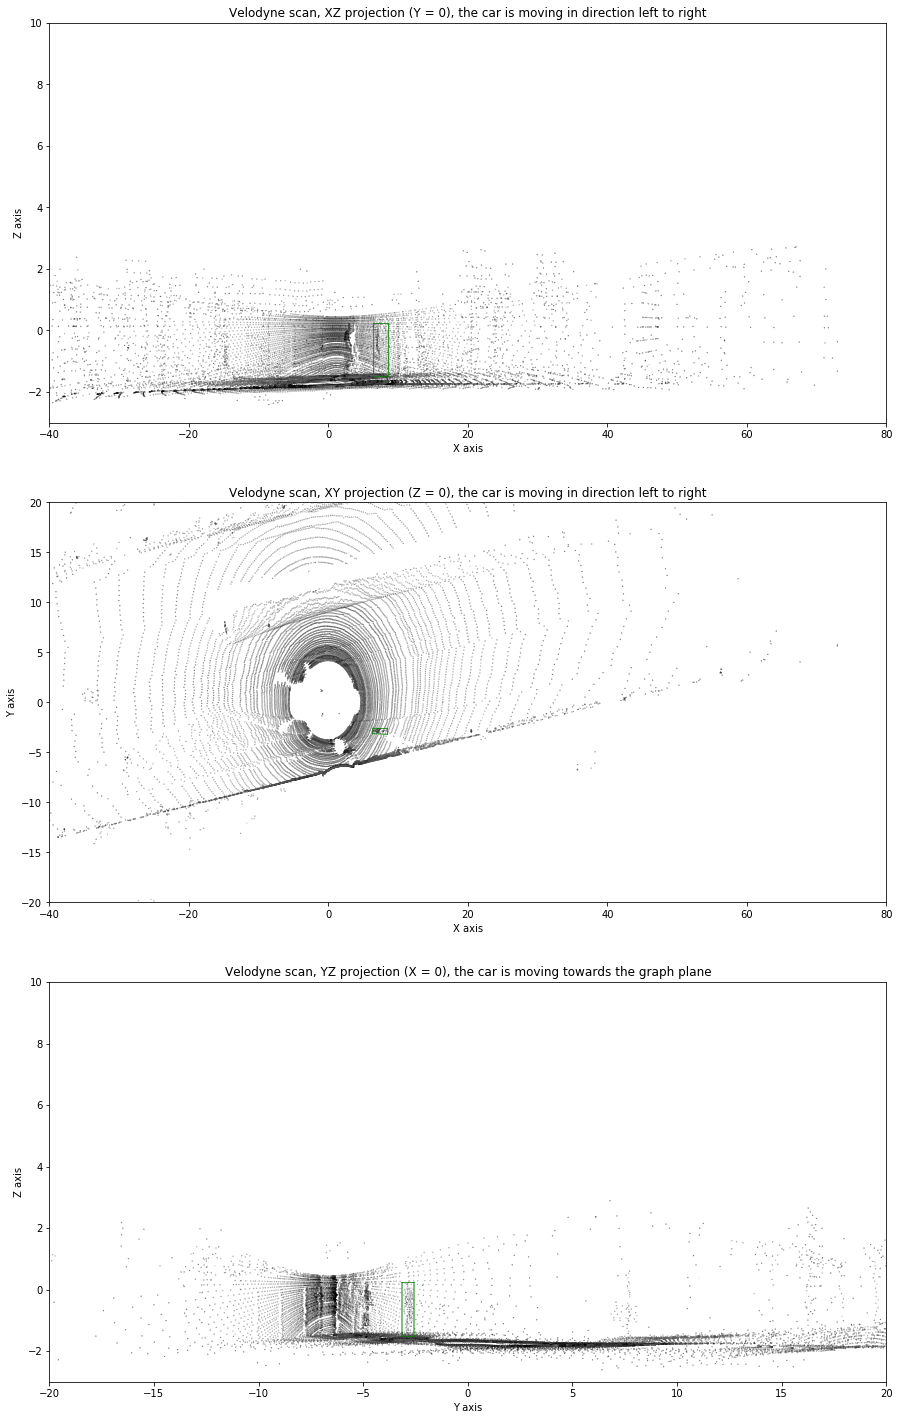

In [14]:
frame = 20
display_frame_statistics(dataset, tracklet_rects, tracklet_types, frame)

In [15]:
# from source.utilities import print_progress
from moviepy.editor import ImageSequenceClip
from utilities import print_progress
def draw_3d_plot(frame, dataset, tracklet_rects, tracklet_types, points=0.2):
    """
    Saves a single frame for an animation: a 3D plot of the lidar data without ticks and all frame trackelts.
    Parameters
    ----------
    frame           : Absolute number of the frame.
    dataset         : `raw` dataset.
    tracklet_rects  : Dictionary with tracklet bounding boxes coordinates.
    tracklet_types  : Dictionary with tracklet types.
    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.

    Returns
    -------
    Saved frame filename.
    """
    f = plt.figure(figsize=(12, 8))
    axis = f.add_subplot(111, projection='3d', xticks=[], yticks=[], zticks=[])

    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    velo_range = range(0, dataset.velo[frame].shape[0], points_step)
    velo_frame = dataset.velo[frame][velo_range, :]
    axis.scatter(*np.transpose(velo_frame[:, [0, 1, 2]]), s=point_size, c=velo_frame[:, 3], cmap='gray')
    axis.set_xlim3d(*axes_limits[0])
    axis.set_ylim3d(*axes_limits[1])
    axis.set_zlim3d(*axes_limits[2])
    for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
        draw_box(axis, t_rects, axes=[0, 1, 2], color=colors[t_type])
    filename = 'video/frame_{0:0>4}.png'.format(frame)
    plt.savefig(filename)
    plt.close(f)
    return filename

frames = []
n_frames = len(dataset.velo)

# print('Preparing animation frames...')
# for i in range(n_frames):
#     print_progress(i, n_frames - 1)
#     filename = draw_3d_plot(i, dataset, tracklet_rects, tracklet_types)
#     frames += [filename]
# print('...Animation frames ready.')

# clip = ImageSequenceClip(frames, fps=5)
# % time
# clip.write_gif('pcl_data.gif', fps=5)


Rigid body transformation from Velodyne coordinates to camera coordinates given in calib_velo_to_cam.txt

http://www.mrt.kit.edu/z/publ/download/2013/GeigerAl2013IJRR.pdf
    
$R^{cam}_{velo} \in\mathbb{R}^{3 \times 3}$ Rotation matrix: Velodyne $\to$ camera

$t^{cam}_{velo} \in\mathbb{R}^{1 \times 3}$ Translation vector: Velodyne $\to$ camera

Using: 

$T^{cam}_{velo} = \begin{bmatrix}
    R^{cam}_{velo} & t^{cam}_{velo}  \\
    0 & 1
  \end{bmatrix}$
  
A 3D point $x$ in Velodyne cooridnates gets projected to a point $y$ in the $ith$ camera image as

$y = P^{(i)}_{rect} R^{(0)}_{rect}T^{cam}_{velo}x$

Where $P^{(i)}_{rect} = 
    \begin{bmatrix}
    f^{(i)}_{u} & 0 & c^{(i)}_{u} & -f^{(i)}_{u}b^{(i)}_{x} \\
    0 & f^{(i)}_{v} & c^{(i)}_{v} & 0\\
    0 & 0 & 1 & 0
    \end{bmatrix}
$

In [16]:
import dataset_utility as du

In [17]:
calib_dir = 'data/2011_09_26/'
cam_to_cam_filename = 'calib_cam_to_cam.txt'
velo_to_cam_filename = 'calib_velo_to_cam.txt'
# cam = du.loadCalibrationCamToCam(calib_dir + cam_to_cam_filename, verbose=True)
velo_to_cam = du.loadCalibrationRigid(calib_dir + velo_to_cam_filename, verbose=True)

R [[ 0.0075 -1.     -0.0006]
 [ 0.0148  0.0007 -0.9999]
 [ 0.9999  0.0075  0.0148]]
T [[-0.0041]
 [-0.0763]
 [-0.2718]]
Tr [[ 0.0075 -1.     -0.0006 -0.0041]
 [ 0.0148  0.0007 -0.9999 -0.0763]
 [ 0.9999  0.0075  0.0148 -0.2718]
 [ 0.      0.      0.      1.    ]]


In [120]:
%matplotlib inline
l_and = lambda *x: np.logical_and.reduce(x)
def convert_velo_cord_to_img(data_set, calib_dir, cam=2, frame=20):
    """
    Demostrates projection of the velodyne points into the image plane
    Parameters
    ----------
    base_dir  : Absolute path to sequence base directory (ends with _sync)
    calib_dir : Absolute path to directory that contains calibration files
    Returns
    -------
    """
#     0-based index
#     cam = 2
#     frame = 20
#     load calibration
# TODO: use os.path.join?
    calib = du.loadCalibrationCamToCam(calib_dir + 'calib_cam_to_cam.txt')
    Tr_velo_to_cam = du.loadCalibrationRigid(calib_dir + 'calib_velo_to_cam.txt')

#     Compute projection matrix velodyne->image plane
    R_cam_to_rect = np.eye(4, dtype=float)
    R_cam_to_rect[0: 3, 0: 3] = calib['R_rect_00']
    P_velo_to_img = np.dot(np.dot(calib['P_rect_0' + str(cam)], R_cam_to_rect), Tr_velo_to_cam)
#     print(type(R_cam_to_rect))
#     Load image and display
#   Load velodyne points
# Take 1 of 5 points for display speed
    velo = data_set.velo[0:len(data_set.velo):5][0]
#     print('data_set velo', data_set.velo[frame])
    velo_data = data_set.velo[frame]
    velo = velo_data[0:velo_data.shape[0]:5]
    
    img_h, img_w, img_ch = dataset.rgb[frame].right.shape
    
    img_plane_depth = 5
    x_dir_pts = velo[:, 0]
    filtered_x_dir_indices = l_and((x_dir_pts > img_plane_depth))
#     .flatten to remove extra dimension
    indices = np.argwhere(filtered_x_dir_indices).flatten()
#     Depth (x) limited velodyne points
    velo = velo[indices, :]
#     Project to image plane (exclude luminance/intensity)
    velo_img = du.project(velo[:, 0:3], P_velo_to_img)
    
    return velo_img

In [146]:
def crop_velo_to_img_size(img_shape, velo_data):
    """
    Parameters:
    ----------
    img_size: camera image size
    velo_data :calibrated and project transformed lidar to camera data
    """
    img_h = img_shape[0]
    img_w = img_shape[1]
    img_dim_x_pts = velo_data[:, 0]
    img_dim_y_pts = velo_data[:, 1]
    
    x_filt = l_and((img_dim_x_pts < img_w), (img_dim_x_pts >= 0))
    y_filt = l_and((img_dim_y_pts < img_h), (img_dim_y_pts >= 0))
    filtered = l_and(x_filt, y_filt)
    indices = np.argwhere(filtered).flatten()
    
    img_dim_x_pts = img_dim_x_pts[indices]
    img_dim_y_pts = img_dim_y_pts[indices]
    return (img_dim_x_pts, img_dim_y_pts)

<built-in function addWeighted>
3819
3819


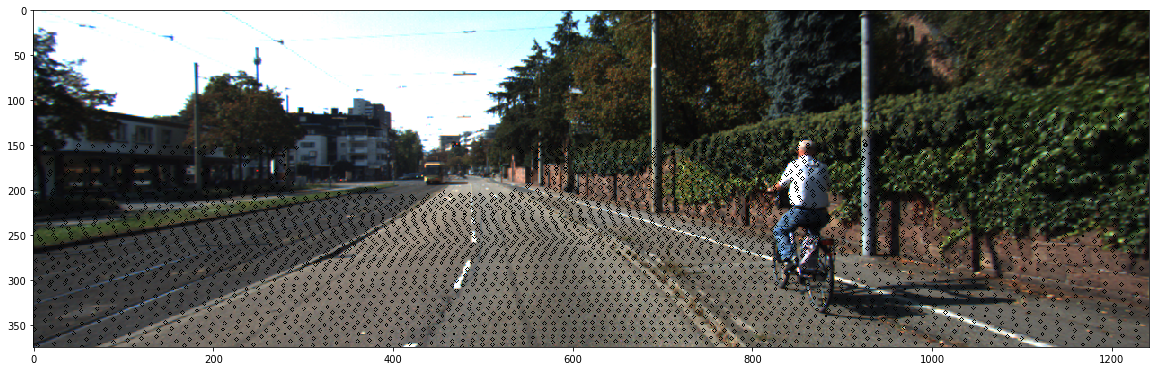

In [174]:
velo_data = convert_velo_cord_to_img(dataset, calib_dir)
rgb_img = dataset.rgb[frame].right
corped_velo_data = crop_velo_to_img_size(rgb_img.shape, velo_data)


import cv2
print(cv2.addWeighted)
def overlay_velo_img(img, velo_data):
    (x, y) = velo_data
    im = np.zeros(img.shape, dtype=np.float32)
    x_axis = np.floor(x).astype(np.int32)
    y_axis = np.floor(y).astype(np.int32)
#     im[y_axis, x_axis] = [1, 0, 1]
    print(len(x))
    print(len(y))
    for i in range(0, len(x)):
#         cv2.circle(img, center, radius, color, thickness=1, lineType=8, shift=0)
        cv2.circle(img, (x_axis[i], y_axis[i]), 2, [0, 35, 0])
    
    fig1 = plt.figure(figsize=(20, 20))
    plt.imshow(img)

overlay_velo_img(rgb_img, corped_velo_data)


In [162]:
# R = run_demoVelodyne(, calib_dir)